In [1]:
print("Code Checker")

Code Checker


# Import 

In [5]:
import os, json, math, textwrap
import numpy as np
import pandas as pd

from pathlib import Path
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LinearRegression
from scipy.signal import savgol_filter

DATA_DIR = Path("../Data")
RAW = DATA_DIR / "raw" / "raw_battery_dataset.csv"
PROC_DIR = DATA_DIR / "processed"
RES_DIR = DATA_DIR / "results"
PROC_DIR.mkdir(parents=True, exist_ok=True)
RES_DIR.mkdir(parents=True, exist_ok=True)
RAW


PosixPath('../Data/raw/raw_battery_dataset.csv')

# CSV Load

In [6]:
# Read with robust options (handles stray commas/na)
df_raw = pd.read_csv(RAW)
print(df_raw.shape)
df_raw.head()


(680, 11)


,battery_id,cycle,chI,chV,chT,disI,disV,disT,BCt,SOH,RUL
0,B5,1,1.440147,4.254682,23.988733,1.894407,3.273523,32.980834,1.986196,99.309790,219
1,B5,2,1.416595,4.159825,25.665347,1.829949,4.038741,32.257920,1.986240,99.311985,218
2,B5,3,1.420272,4.276323,25.407910,1.942105,3.214433,35.134801,1.984252,99.212608,217
3,B5,4,1.337680,4.236697,27.069757,2.073577,3.134529,32.082988,1.969236,98.461812,216
4,B5,5,1.263946,4.142791,26.478353,2.049885,3.729341,32.483154,1.974862,98.743106,215


#### Battery_id - EACH CELL
#### cycle - Indicates Test Cycle Number: A FULL CHARGE + DISCHARGE COUNTS AS 1 CYCLE 
#### chl - CHARGING CURRENT
#### chv - CHARGING VOLTAGE
#### cht - CHARGING TEMPERATURE
#### disl - DISCHARGING CURRENT - CURRENT DRAWN WHILE DISCHARGE
#### disv - DISCHARGING VOLTAGE - VOLTAGE DRAWN WHILE DISCHARGE
#### dist - DISCHARGING TEMPERATURE - TEMPERATURE DRAWN WHILE DISCHARGE
#### BCt - BATTERY CAPACITY - HOW MUCH CHARGE A CELL CAN STORE
#### SOH - STATE OF HEALTH
#### RUL - REMAINING USEFUL LIFE



In [7]:
# === Canonical Mapping (specific to Kaggle Li-ion dataset) ===
canonical_map = {
    "battery_id": "battery_id",        # identifier
    "cycle": "cycle",                  # cycle index
    "chI": "charge_current",           # charging current (A)
    "chV": "charge_voltage",           # charging voltage (V)
    "chT": "charge_temp",              # charging temperature (°C)
    "disI": "discharge_current",       # discharging current (A)
    "disV": "discharge_voltage",       # discharging voltage (V)
    "disT": "discharge_temp",          # discharging temperature (°C)
    "BCt": "capacity",                 # battery capacity (Ah)
    "SOH": "soh",                      # state of health (%)
    "RUL": "rul"                       # remaining useful life (cycles)
}

df = df_raw.rename(columns=canonical_map)
df = df[list(canonical_map.values())]

# Ensure numeric columns are clean
num_cols = [
    "cycle", "charge_current", "charge_voltage", "charge_temp",
    "discharge_current", "discharge_voltage", "discharge_temp",
    "capacity", "soh", "rul"
]
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors="coerce")

# Sort for consistency
df = df.sort_values(by=["battery_id", "cycle"]).reset_index(drop=True)
print(df.shape)
df.head()


(680, 11)


,battery_id,cycle,charge_current,charge_voltage,charge_temp,discharge_current,discharge_voltage,discharge_temp,capacity,soh,rul
0,B5,1,1.440147,4.254682,23.988733,1.894407,3.273523,32.980834,1.986196,99.309790,219
1,B5,2,1.416595,4.159825,25.665347,1.829949,4.038741,32.257920,1.986240,99.311985,218
2,B5,3,1.420272,4.276323,25.407910,1.942105,3.214433,35.134801,1.984252,99.212608,217
3,B5,4,1.337680,4.236697,27.069757,2.073577,3.134529,32.082988,1.969236,98.461812,216
4,B5,5,1.263946,4.142791,26.478353,2.049885,3.729341,32.483154,1.974862,98.743106,215


# PREPROCESS

In [8]:
# === Cleaning ===
df_clean = df.copy()

# Interpolate and fill missing data
df_clean[num_cols] = df_clean[num_cols].interpolate(limit_direction="both")
df_clean[num_cols] = df_clean[num_cols].fillna(method="bfill").fillna(method="ffill")

# Verify per-battery data ranges
summary = df_clean.groupby("battery_id").agg({
    "cycle": ["min", "max"],
    "capacity": ["min", "max"],
    "soh": ["min", "max"],
    "rul": ["min", "max"]
}).round(3)

summary


/var/folders/6y/8rwnfv1s3855864m6xpflvj00000gn/T/ipykernel_13420/945817531.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_clean[num_cols] = df_clean[num_cols].fillna(method="bfill").fillna(method="ffill")


cycle      capacity            soh         rul     
             min  max      min    max     min     max min  max
battery_id                                                    
B5             1  220    0.898  1.986  44.913  99.312   0  219
B6             1  210    0.942  1.994  47.110  99.685   0  209
B7             1  250    0.751  1.991  37.549  99.545   0  249

# SIGNAL SMOOTHING 

In [9]:
from scipy.signal import savgol_filter
import numpy as np
import pandas as pd

# Columns to smooth
SMOOTH_COLS = ["charge_voltage","discharge_voltage","charge_temp","discharge_temp","capacity"]

def sg_safe(x, window=11, polyorder=2):
    x = np.asarray(x)
    n = len(x)
    # enforce odd window and >= poly+2
    w = max(window, polyorder + 2 if (polyorder + 2) % 2 == 1 else polyorder + 3)
    if n < w: 
        w = max(3, n - (1 - n % 2))  # nearest odd <= n
    if w < 3: 
        return x
    try:
        return savgol_filter(x, w, polyorder)
    except ValueError:
        return x

def ema_vec(x, span=10):
    return pd.Series(x).ewm(span=span, adjust=False).mean().values

# --- (Optional) small auto-tuner per-battery+signal ---
def choose_sg_window(series, candidates=(7,9,11,13,15)):
    x = np.asarray(series)
    best_w, best_score = None, np.inf
    for w in candidates:
        xs = sg_safe(x, window=w, polyorder=2)
        resid = x - xs
        rough = np.var(np.diff(xs))           # smoother wants lower
        fiterr = np.var(resid)                # don’t drift far from data
        score = 0.6*rough + 0.4*fiterr        # weight shape more than fit
        if score < best_score:
            best_w, best_score = w, score
    return best_w or 11

# Apply smoothing per battery_id to respect trajectories
df_smooth = df_clean.copy()
for bid, g in df_smooth.groupby("battery_id"):
    idx = g.index
    # auto-pick one SG window per battery for consistency
    ref_window = choose_sg_window(g["capacity"].values) if "capacity" in g else 11
    for col in SMOOTH_COLS:
        if col in g:
            df_smooth.loc[idx, f"{col}_sg"]  = sg_safe(g[col].values, window=ref_window, polyorder=2)
            df_smooth.loc[idx, f"{col}_ema"] = ema_vec(g[col].values, span=10)

# Replace df_clean with smoothed frame for downstream cells
df_clean = df_smooth

# Quick quality check metrics (optional display)
def smoothing_qc(raw, smooth):
    resid = raw - smooth
    return {
        "resid_std": float(np.nanstd(resid)),
        "derivative_roughness": float(np.nanvar(np.diff(smooth)))
    }

qc_report = {}
for col in SMOOTH_COLS:
    if f"{col}_sg" in df_clean:
        qc_report[col] = smoothing_qc(df_clean[col].values, df_clean[f"{col}_sg"].values)
qc_report


{'charge_voltage': {'resid_std': 0.04186645901180995,
  'derivative_roughness': 0.00016502358598027129},
 'discharge_voltage': {'resid_std': 0.26353847947908626,
  'derivative_roughness': 0.0064116521485236624},
 'charge_temp': {'resid_std': 1.3166496307241928,
  'derivative_roughness': 0.16459058134095864},
 'discharge_temp': {'resid_std': 1.5956915632270232,
  'derivative_roughness': 0.24668977201018358},
 'capacity': {'resid_std': 0.004118676748971825,
  'derivative_roughness': 0.0033926097284148844}}

# Feature Eng

In [11]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

# ---- Helper: rolling linear regression slope ----
def rolling_slope(y, window=20):
    """
    Compute local slope (1st-order trend) over a sliding window.
    The result has the same length as y, filled with NaN for the first (window-1) entries.
    """
    y = np.asarray(y)
    n = len(y)
    out = np.full(n, np.nan)
    X = np.arange(n).reshape(-1, 1)
    for i in range(window - 1, n):
        sl = slice(i - window + 1, i + 1)
        reg = LinearRegression().fit(X[sl], y[sl])
        out[i] = reg.coef_[0]
    return out


# ---- Start with your smoothed DataFrame from Cell 5 ----
df_feat = df_clean.copy()

# Compute Δ capacity and Δ temperature between successive cycles
df_feat["capacity_diff"] = df_feat.groupby("battery_id")["capacity"].diff()
df_feat["discharge_temp_diff"] = df_feat.groupby("battery_id")["discharge_temp_sg"].diff()
df_feat["charge_temp_diff"] = df_feat.groupby("battery_id")["charge_temp_sg"].diff()

# ---- Rolling slopes for capacity and voltage trends ----
df_feat["capacity_trend"] = (
    df_feat.groupby("battery_id")["capacity"].transform(lambda s: rolling_slope(s.values, window=25))
)

df_feat["voltage_trend"] = (
    df_feat.groupby("battery_id")["discharge_voltage_sg"].transform(lambda s: rolling_slope(s.values, window=25))
)

# ---- Optional: combine temperature and capacity slopes to form a degradation index ----
df_feat["degradation_index"] = (
    -df_feat["capacity_trend"].fillna(0) * (1 + 0.05 * df_feat["discharge_temp_sg"].fillna(0))
)

# ---- Quick inspection ----
cols_show = [
    "battery_id", "cycle",
    "capacity", "capacity_diff", "capacity_trend",
    "discharge_voltage_sg", "voltage_trend",
    "discharge_temp_sg", "degradation_index"
]
df_feat[cols_show].head(15)


,battery_id,cycle,capacity,capacity_diff,capacity_trend,discharge_voltage_sg,voltage_trend,discharge_temp_sg,degradation_index
0,B5,1,1.986196,NaN,NaN,3.586320,NaN,32.665136,-0.0
1,B5,2,1.986240,0.000044,NaN,3.464015,NaN,33.075559,-0.0
2,B5,3,1.984252,-0.001988,NaN,3.381713,NaN,33.381165,-0.0
3,B5,4,1.969236,-0.015016,NaN,3.339415,NaN,33.581955,-0.0
4,B5,5,1.974862,0.005626,NaN,3.337120,NaN,33.677928,-0.0
5,B5,6,1.976299,0.001437,NaN,3.287637,NaN,33.669363,-0.0
6,B5,7,1.965698,-0.010601,NaN,3.491188,NaN,33.859205,-0.0
7,B5,8,1.959159,-0.006538,NaN,3.585124,NaN,33.512047,-0.0
8,B5,9,1.957507,-0.001652,NaN,3.633970,NaN,32.670649,-0.0
9,B5,10,1.951182,-0.006325,NaN,3.911256,NaN,32.168098,-0.0


# Model Training

In [12]:
# === Cell 7: Multi-Model Anomaly Detection ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope

# Features to analyze
FEATURES = [
    "capacity", "capacity_diff", "capacity_trend",
    "voltage_trend", "discharge_temp_sg", "degradation_index"
]

# Keep clean subset and drop NaN rows
df_model = df_feat[FEATURES + ["battery_id", "cycle"]].dropna().copy()

X = df_model[FEATURES].values

# --- Model 1: Isolation Forest ---
iso = IsolationForest(n_estimators=200, contamination=0.03, random_state=42)
iso_pred = iso.fit_predict(X)
df_model["anomaly_iso"] = (iso_pred == -1).astype(int)
df_model["score_iso"] = iso.decision_function(X)

# --- Model 2: Local Outlier Factor ---
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.03)
lof_pred = lof.fit_predict(X)
df_model["anomaly_lof"] = (lof_pred == -1).astype(int)
df_model["score_lof"] = lof.negative_outlier_factor_

# --- Model 3: One-Class SVM ---
ocsvm = OneClassSVM(kernel="rbf", gamma=0.1, nu=0.03)
svm_pred = ocsvm.fit_predict(X)
df_model["anomaly_svm"] = (svm_pred == -1).astype(int)
df_model["score_svm"] = ocsvm.decision_function(X)

# --- Model 4: Elliptic Envelope ---
ee = EllipticEnvelope(contamination=0.03, random_state=42)
ee_pred = ee.fit_predict(X)
df_model["anomaly_ee"] = (ee_pred == -1).astype(int)
df_model["score_ee"] = ee.decision_function(X)

# --- Summary comparison table ---
summary = (
    df_model[["anomaly_iso","anomaly_lof","anomaly_svm","anomaly_ee"]]
    .sum()
    .rename("Anomaly_Count")
    .to_frame()
)
summary["Anomaly_%"] = 100*summary["Anomaly_Count"]/len(df_model)
display(summary.round(2))

# Save results
res_dir = Path("../Data/results")
res_dir.mkdir(parents=True, exist_ok=True)
df_model.to_csv(res_dir/"anomaly_comparison_all_models.csv", index=False)
print("✅ All model outputs saved to Data/results/")


,Anomaly_Count,Anomaly_%
anomaly_iso,19,3.12
anomaly_lof,19,3.12
anomaly_svm,18,2.96
anomaly_ee,19,3.12


✅ All model outputs saved to Data/results/


In [13]:
import plotly.express as px

def plot_anomalies(df, model_col, title):
    fig = px.scatter(
        df, x="cycle", y="capacity",
        color=df[model_col].map({0:"Normal", 1:"Anomaly"}),
        title=title,
        symbol=df[model_col].map({0:"circle",1:"x"}),
        opacity=0.8,
        color_discrete_map={"Normal":"#00CC96","Anomaly":"#EF553B"}
    )
    fig.update_traces(marker=dict(size=6))
    fig.show()

for model in ["iso","lof","svm","ee"]:
    plot_anomalies(df_model, f"anomaly_{model}", f"Anomalies Detected by {model.upper()}")


In [14]:
df_model["anomaly_sum"] = (
    df_model[["anomaly_iso","anomaly_lof","anomaly_svm","anomaly_ee"]].sum(axis=1)
)

# 0 = normal by all, 4 = anomaly by all
df_model["agreement_level"] = df_model["anomaly_sum"].map({
    0:"Normal (All agree)",
    1:"1 model flagged",
    2:"2 models flagged",
    3:"3 models flagged",
    4:"All models flagged"
})

fig = px.scatter(
    df_model, x="cycle", y="capacity",
    color="agreement_level",
    title="Model Agreement on Detected Anomalies",
    color_discrete_sequence=px.colors.qualitative.Dark24,
    opacity=0.8
)
fig.update_traces(marker=dict(size=6))
fig.show()


/opt/anaconda3/lib/python3.11/site-packages/plotly/express/_core.py:1979: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



/opt/anaconda3/lib/python3.11/site-packages/plotly/express/_core.py:1979: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



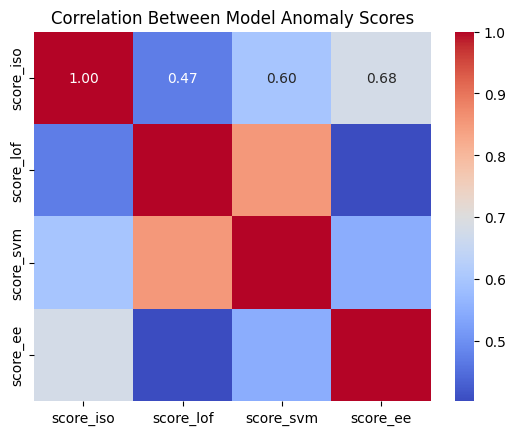

In [16]:
# === Cell 8: Compare model overlaps and correlations ===
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.figure_factory as ff
import seaborn as sns
import matplotlib.pyplot as plt

# Binary anomaly columns
anomaly_cols = ["anomaly_iso","anomaly_lof","anomaly_svm","anomaly_ee"]

# ---- 1️⃣ Overlap / Agreement Matrix ----
agree = pd.DataFrame(index=anomaly_cols, columns=anomaly_cols, dtype=float)
for a in anomaly_cols:
    for b in anomaly_cols:
        inter = np.logical_and(df_model[a]==1, df_model[b]==1).sum()
        union = np.logical_or(df_model[a]==1, df_model[b]==1).sum()
        agree.loc[a,b] = inter/union if union>0 else 0.0

fig = px.imshow(
    agree, text_auto=True, color_continuous_scale="Blues",
    title="Model Agreement (Jaccard Similarity: 1 = full overlap)"
)
fig.show()

# ---- 2️⃣ Anomaly Counts Bar Plot ----
count_df = (
    df_model[anomaly_cols].sum().reset_index()
    .rename(columns={"index":"Model",0:"Anomaly_Count"})
)
count_df["Percent"] = 100*count_df["Anomaly_Count"]/len(df_model)
fig2 = px.bar(
    count_df, x="Model", y="Percent",
    color="Model", title="Anomaly % per Model",
    text=round(count_df["Percent"],2),
    color_discrete_sequence=px.colors.qualitative.Dark2
)
fig2.update_traces(textposition="outside")
fig2.show()

# ---- 3️⃣ Correlation between model scores ----
score_cols = ["score_iso","score_lof","score_svm","score_ee"]
corr = df_model[score_cols].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Model Anomaly Scores")
plt.show()


In [17]:
# === Cell 9: Top-N Anomalies Exploration ===
import pandas as pd
import numpy as np
import plotly.express as px
from pathlib import Path

# --- Parameters ---
TOP_N = 25  # number of top anomalies to inspect
SAVE_PATH = Path("../Data/results/top_anomalies.csv")

# --- 1️⃣ Compute an ensemble anomaly score ---
# Normalize individual model scores (higher = more anomalous)
def normalize_series(s):
    s = pd.Series(s)
    return (s - s.min()) / (s.max() - s.min())

for sc in ["score_iso", "score_lof", "score_svm", "score_ee"]:
    df_model[f"{sc}_norm"] = normalize_series(df_model[sc])

# Combine all normalized scores (higher = more likely anomaly)
df_model["ensemble_score"] = (
    df_model[["score_iso_norm", "score_lof_norm", "score_svm_norm", "score_ee_norm"]].mean(axis=1)
)

# --- 2️⃣ Sort and extract top anomalies ---
df_top = (
    df_model.sort_values("ensemble_score", ascending=False)
    .head(TOP_N)
    .reset_index(drop=True)
)

# Add a quick descriptor of which models agreed
df_top["models_flagged"] = (
    df_top[["anomaly_iso","anomaly_lof","anomaly_svm","anomaly_ee"]].sum(axis=1)
)

# --- 3️⃣ Display summary ---
cols_show = [
    "battery_id","cycle","capacity","discharge_temp_sg",
    "capacity_trend","voltage_trend",
    "ensemble_score","models_flagged"
]
display(df_top[cols_show].round(4))

# --- 4️⃣ Save results ---
SAVE_PATH.parent.mkdir(parents=True, exist_ok=True)
df_top.to_csv(SAVE_PATH, index=False)
print(f"✅ Top {TOP_N} anomalies saved to: {SAVE_PATH}")

# --- 5️⃣ Visualize Top Anomalies on Capacity Curve ---
fig = px.scatter(
    df_model, x="cycle", y="capacity",
    color="ensemble_score", color_continuous_scale="RdYlBu_r",
    title=f"Top {TOP_N} Anomalies Highlighted by Ensemble Score",
    hover_data=["battery_id","cycle","ensemble_score"],
    opacity=0.7
)
# Overlay Top anomalies
fig.add_scatter(
    x=df_top["cycle"], y=df_top["capacity"],
    mode="markers", marker=dict(size=10, color="red", symbol="x"),
    name="Top Anomalies"
)
fig.show()


,battery_id,cycle,capacity,discharge_temp_sg,capacity_trend,voltage_trend,ensemble_score,models_flagged
0,B7,121,1.3986,33.5437,-0.0051,0.0028,0.9863,0
1,B7,125,1.3798,33.3895,-0.0051,-0.0030,0.9834,0
2,B7,148,1.2662,33.4394,-0.0049,-0.0002,0.9816,0
3,B5,119,1.4012,33.0274,-0.0051,-0.0049,0.9804,0
4,B6,98,1.5112,33.4019,-0.0050,0.0013,0.9803,0
5,B7,95,1.5334,33.2024,-0.0049,-0.0003,0.9787,0
6,B7,127,1.3615,33.0776,-0.0050,-0.0029,0.9781,0
7,B6,121,1.3987,33.3785,-0.0051,0.0031,0.9773,0
8,B6,127,1.3704,33.2941,-0.0050,0.0078,0.9772,0
9,B7,145,1.2716,33.2295,-0.0049,-0.0009,0.9769,0


✅ Top 25 anomalies saved to: ../Data/results/top_anomalies.csv
